## 1. Data Exploration

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
# Display output of all code lines in Jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [13]:
# to reproduce results
rseed = 220
rng = np.random.RandomState(rseed)

In [4]:
import os
if os.path.exists('/content/imageProcessing') == False:
  !git clone https://github.com/amrik220/imageProcessing

In [5]:
# load data labels from the csv file
# data = pd.read_csv('./emergency_class_labels.csv')
data = pd.read_csv('/content/imageProcessing/facial_keypoint_identification/facial_keypoint_identification.csv')

data.head()
data.shape

,image_name,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y
0,0.jpg,66,39,30,36
1,1.jpg,64,34,29,33
2,2.jpg,65,34,30,34
3,3.jpg,65,37,32,37
4,4.jpg,66,39,32,38


(7033, 5)

Shape of original image is (96, 96, 3)


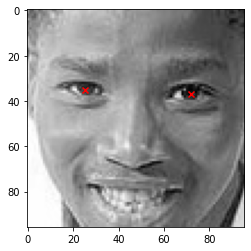

In [6]:
# get random index of data
idx = rng.choice(data.index)

path = '/content/imageProcessing/facial_keypoint_identification/images/'
# read image
img = plt.imread(path + data.image_name.iloc[idx])

# create an empty figure to plot the image and target
fig = plt.figure()

# plot image
plt.imshow(img)

# plot target
plt.scatter(data.left_eye_center_x.iloc[idx], data.left_eye_center_y.iloc[idx], marker='x', c='r')
plt.scatter(data.right_eye_center_x.iloc[idx], data.right_eye_center_y.iloc[idx], marker='x', c='r')

# and print the shape of image
print('Shape of original image is', img.shape)

# finally show the figure
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error

In [8]:
error_left_x = mean_squared_error(data.left_eye_center_x.values, np.full(data.left_eye_center_x.values.shape, data.left_eye_center_x.mean()))
error_left_y = mean_squared_error(data.left_eye_center_y.values, np.full(data.left_eye_center_y.values.shape, data.left_eye_center_y.mean()))
error_right_x = mean_squared_error(data.right_eye_center_x.values, np.full(data.right_eye_center_x.values.shape, data.right_eye_center_x.mean()))
error_right_y = mean_squared_error(data.right_eye_center_y.values, np.full(data.right_eye_center_y.values.shape, data.right_eye_center_y.mean()))

error = (error_left_x*error_left_x + error_left_y*error_left_y + error_right_x*error_right_x + error_right_y*error_right_y ) / 4
error

104.5789947402131

## 2. Load and preprocess data

In [9]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [10]:
images = []
for img in data.image_name:
    img = image.load_img(path + img, target_size=(224, 224, 3))
    img = image.img_to_array(img)
    images.append(img)
    
images=np.array(images)

In [11]:
images.shape

(7033, 224, 224, 3)

In [12]:
# import keras
# keras.__version__
# !pip install Keras==2.3.1
# !pip install TensorFlow==1.14

In [14]:
X=preprocess_input(images, mode='tf')
y = data.iloc[:, 1:].values

In [15]:
X_train, X_valid, Y_train, Y_valid=train_test_split(X,y,test_size=0.3, random_state=rseed)

## 3. Model Building

In [16]:
from keras.applications.vgg16 import VGG16

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, InputLayer
from keras.callbacks import EarlyStopping

In [17]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))


58892288/58889256 [==============================] - 1s 0us/step


In [18]:
features_train = base_model.predict(X_train)
features_valid = base_model.predict(X_valid)

In [19]:
features_train.max()

10.832217

In [20]:
max_val = features_train.max()

In [21]:
features_train /= max_val
features_valid /= max_val

In [22]:
features_train = features_train.reshape(features_train.shape[0], 7*7*512)
features_valid = features_valid.reshape(features_valid.shape[0], 7*7*512)

In [23]:
model=Sequential()
model.add(InputLayer((7*7*512, )))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=4, activation='linear'))

adam = Adam(lr=1e-3)
model.compile(loss='mean_squared_error', optimizer=adam)

In [24]:
estop = EarlyStopping(patience=10, mode='min', min_delta=0.001, monitor='val_loss')

In [25]:
model.fit(features_train, Y_train, epochs=200, batch_size=512, callbacks=[estop] ,validation_data=(features_valid,Y_valid))

Train on 4923 samples, validate on 2110 samples
Epoch 1/200
4923/4923 [==============================] - 14s 3ms/step - loss: 1121.0408 - val_loss: 140.1609
Epoch 2/200
4923/4923 [==============================] - 13s 3ms/step - loss: 153.3663 - val_loss: 167.4665
Epoch 3/200
4923/4923 [==============================] - 13s 3ms/step - loss: 87.9705 - val_loss: 57.8649
Epoch 4/200
4923/4923 [==============================] - 13s 3ms/step - loss: 57.0720 - val_loss: 35.1916
Epoch 5/200
4923/4923 [==============================] - 13s 3ms/step - loss: 34.4948 - val_loss: 24.0079
Epoch 6/200
4923/4923 [==============================] - 13s 3ms/step - loss: 27.9442 - val_loss: 18.5423
Epoch 7/200
4923/4923 [==============================] - 13s 3ms/step - loss: 23.2914 - val_loss: 16.5014
Epoch 8/200
4923/4923 [==============================] - 13s 3ms/step - loss: 21.0257 - val_loss: 14.6976
Epoch 9/200
4923/4923 [==============================] - 13s 3ms/step - loss: 19.3549 - val_loss: 1

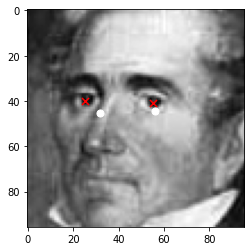

In [27]:
# get predictions
predictions = model.predict(features_valid)

# extract validation images
_, valid_images, _, _ = train_test_split(data.image_name,y,test_size=0.3, random_state=42)

# get random validation image index
idx = rng.choice(range(len(valid_images)))

# get the corresponding image name
image_name = valid_images.iloc[idx]

# get the actual targets
left_eye_center_x = data.loc[data.image_name == image_name, 'left_eye_center_x']
left_eye_center_y = data.loc[data.image_name == image_name, 'left_eye_center_y']
right_eye_center_x = data.loc[data.image_name == image_name, 'right_eye_center_x']
right_eye_center_y = data.loc[data.image_name == image_name, 'right_eye_center_y']

# get the corresponding predictions
predicted_left_eye_center_x, predicted_left_eye_center_y, predicted_right_eye_center_x, predicted_right_eye_center_y = predictions[idx]

# read the image
img = plt.imread(path + image_name)

# plot empty figure
fig = plt.figure()

# plot image
plt.imshow(img,cmap='gray')

# plot actual targets
plt.scatter(left_eye_center_x, left_eye_center_y, marker='x', s=50, c='r')
plt.scatter(right_eye_center_x, right_eye_center_y, marker='x', s=50, c='r')

# plot predictions
plt.scatter(predicted_left_eye_center_x, predicted_left_eye_center_y, marker='o', s=50, c='w')
plt.scatter(predicted_right_eye_center_x, predicted_right_eye_center_y, marker='o', s=50, c='w')

# show the figure
plt.show()